In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 


# Tiny-shakespeare dataset
Now we will move to a real world task, next-character prediction with the tiny-shakespeare dataset

In [9]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [10]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

sequence_length = 1
vocab_size = len(texttoint)
inputs = torch.tensor(dataset[:-1])
labels = torch.tensor(dataset[1:])
print(vocab_size)

65


**One-hot encoding** converts class labels into binary vectors, making them orthogonal. Neural networks excel at recognizing vector orthogonality, unlike differences in raw integer values. 

For 4 classes (0–3):  
- Class 0 → `[1, 0, 0, 0]`  
- Class 1 → `[0, 1, 0, 0]`  
- Class 2 → `[0, 0, 1, 0]`  
- Class 3 → `[0, 0, 0, 1]`  


In [11]:
onehot = F.one_hot(inputs[:4].long(), 65).float()
print(inputs[:4])
print(onehot)

tensor([ 9, 48, 37, 31])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
   

# Perceptron
This complex dataset requires us to build on logistic regression and scale it a lot to make an architecture that can deal with this kind of data  <br>
We are starting with the Perceptron and we are training in batches, the number of features is called vocab_size (65)

In [12]:
m = torch.randn(vocab_size, vocab_size) * (6**0.5 / (vocab_size + vocab_size)**0.5)  
q = torch.zeros(vocab_size) 

m.requires_grad_()
q.requires_grad_()

epochs = 10000  # high number of epochs
lr = 1e-2  # high learning rate
batch_size = 1024  # taking a batch of 1024 samples at a time

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))  # generating random indexes

    pred = F.one_hot(inputs[indexes].long(), vocab_size).float() @ m + q
    loss = F.cross_entropy(pred, labels[indexes])
    loss.backward()

    with torch.no_grad():
        m -= lr * m.grad
        q -= lr * q.grad
        m.grad = None
        q.grad = None
    
    if epoch % (epochs//10) == 0:
        print(loss.item())

4.210656642913818
3.8022375106811523
3.592369318008423
3.4689667224884033
3.3074045181274414
3.3362252712249756
3.276520252227783
3.2556097507476807
3.1522021293640137
3.197908878326416


This is cool, we can achieve a pretty decent loss, but some problems are way harder and can't be tackled with a solution this simple... <br>
Remember what we did earlier? We expanded our logistic regressor to make a Perceptron, now we can try expanding the perceptron in the forward direction <br>
This architecture should resemble a network of biological neurons, this is called Multi Layer Perceptron

# MLP



In [13]:
hidden_size = 128

w1 = torch.randn(vocab_size, hidden_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)  
b1 = torch.zeros(hidden_size) 
w2 = torch.randn(hidden_size, vocab_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)
b2 = torch.zeros(vocab_size)

for p in [w1, b1, w2, b2]:
    p.requires_grad_()

epochs = 10000
lr = 1e-2
batch_size = 1024
lossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    X = F.one_hot(inputs[indexes].long(), vocab_size).float()
    h1 = F.gelu(X @ w1 + b1)
    pred = h1 @ w2 + b2
    loss = F.cross_entropy(pred, labels[indexes])
    lossi.append(loss.item())
    loss.backward()

    with torch.no_grad():
        for p in [w1, b1, w2, b2]:
            p -= lr * p.grad
            p.grad = None

    if epoch % (epochs//10) == 0:
        print(loss.item())

4.1990742683410645
3.503788709640503
3.239089250564575
3.219930648803711
3.0546605587005615
3.0114808082580566
2.8908016681671143
2.9102489948272705
2.891218423843384
2.869784116744995


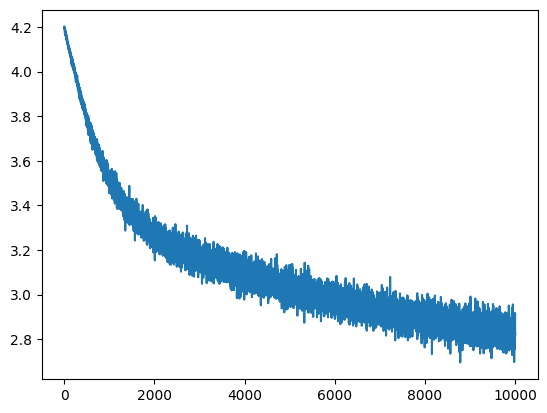

In [15]:
plt.plot(lossi)

Expanding the architecture definetly made the model more effective but as we can see the starting loss is extremely high. <br>
Let's figure that out why by printing some of the values from each layer 

# Optimizer

The architecture looks right but the loss is not going down as well as expected, let's try changing simple gradient descent to a more elaborate optimizer <br>
We won't bother coding this up by ourselves because it's already implemented in pytorch and really easy to use from there <br>
If you want, you can change from torch.optim.Adam to torch.optim.SGD and look how fast Adam really is

In [17]:
hidden_size = 128

w1 = torch.randn(vocab_size, hidden_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)  
b1 = torch.zeros(hidden_size) 
w2 = torch.randn(hidden_size, vocab_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)
b2 = torch.zeros(vocab_size)

for p in [w1, b1, w2, b2]:
    p.requires_grad_()

epochs = 10000
lr = 1e-2
batch_size = 1024
optimizer = torch.optim.Adam([w1, b1, w2, b2], lr=1e-2)
lossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    optimizer.zero_grad()

    X = F.one_hot(inputs[indexes].long(), vocab_size).float()
    h1 = F.gelu(X @ w1 + b1)
    pred = h1 @ w2 + b2
    loss = F.cross_entropy(pred, labels[indexes])
    lossi.append(loss.item())
    loss.backward()
    optimizer.step()

    if epoch % (epochs//10) == 0:
        print(loss.item())

4.16356897354126
2.4757239818573
2.4446163177490234
2.4419875144958496
2.405343532562256
2.4492743015289307
2.4960694313049316
2.4487860202789307
2.4865407943725586
2.4237284660339355


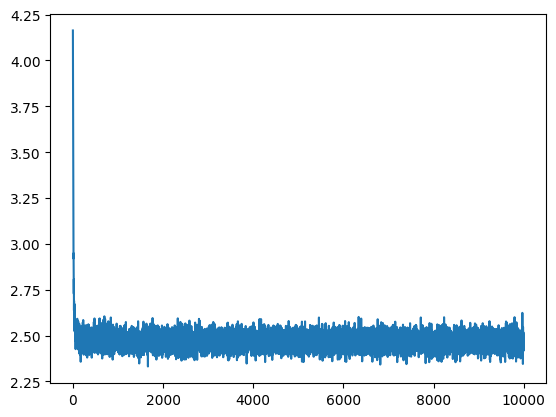

In [18]:
plt.plot(lossi)

# Example output

In [19]:
string = "The meaning of life is: \n"

with torch.no_grad():
    for _ in range(100):
        X = F.one_hot(torch.tensor(texttoint[string[-1]]), vocab_size).float()
        h1 = F.gelu(X @ w1 + b1)
        pred = h1 @ w2 + b2
        string += inttotext[torch.multinomial(F.softmax(pred, dim=0), 1).item()]
        print(string[-1], end="")


Se pouse stounsune:
Pr warte kede.
DWh tllenon, ier te stu helsore fothainde tom, thios.

WBRUYotous